# NoteBook 3 (Analysis Notebook)

In this notebook we analyze the topic change between the president's Obama last 10 Months and president's Trump first 10 twitter. First we will use the word cloud to show the most frequent stemmed words of Trump and Obama's Twitter. Then we will use the LDA to analyze the topic of the president's Obama last 10 Months and president's Trump first 10 twitter. Latent Dirichlet allocation (LDA) is a topic model that generates topics based on word frequency from a set of documents. LDA is particularly useful for finding reasonably accurate mixtures of topics within a given document set. Here's the document of how to use LDA for topic model ([LDA with Python](http://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html)).


In [1]:
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import shelve
from collections import Counter 
import nltk
from os import path
from scipy.misc import imread
import numpy as np
import matplotlib.pyplot as plt
import json
import pyLDAvis.gensim
from gensim import corpora, models
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
warnings.filterwarnings('ignore')

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)


C:\Users\Jim\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Jim\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
#Read the data from notebook 2
with shelve.open('result/vars2') as db:
    obama = db['obama']
    trump = db['trump']

The presidency of every predisent begins at noon EST on January 20. I will select the data from Mar 19, 2016 to Jan 19, 2017 for Obama. And I will select the data from Jan 20, 2017 to Oct 20, 2017 for Trump.

In [3]:
#extract the first 10 months twutter from Trump and Obama
get1 = (obama['created_at'] > '2016-03-19') & (obama['created_at'] <= '2017-01-19')
obama_last10months=obama.loc[get1]
get2 = (trump['created_at'] > '2017-01-20') & (trump['created_at'] <= '2017-10-20')
trump_first10months=trump.loc[get2]

In [4]:
def clean_speech(doc): 
    #Remove the word contain @,& and http
    doc =re.sub(r'\w*\@\w*|\w*\d\w*|\w*\&\w*|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', doc).strip()
    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = get_stop_words('en')
    p_stemmer = PorterStemmer()
    doc1 = doc.lower()
    tokens = tokenizer.tokenize(doc1)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    texts = [p_stemmer.stem(i) for i in stopped_tokens]
    #clean the word if length=1
    #Remove rt, ht, oh,since they are abbreviation of some function in twitter 
    for i in range(len(texts)):
        texts[i] = re.sub(r'\b\w{0,2}\b|\w*\d\w*', '', texts[i])
        texts[i] = re.sub(r'[^a-zA-Z0-9\.]', '', texts[i])
    return texts

obama_cleaned =[clean_speech(i) for i in obama_last10months.text]
trump_cleaned =[clean_speech(i) for i in trump_first10months.text]
flat_list_obama = [item for sublist in obama_cleaned for item in sublist]
flat_list_trump = [item for sublist in trump_cleaned for item in sublist]
obama_twitter=" ".join(flat_list_obama)
trump_twitter=" ".join(flat_list_trump)

## Let's see the Most Frequent Stemmed Words of Obama's Twitter

We use the an Obama photo in `fig` folder to most the word cloud of the most frequent stemmed words of Obama's Twitter

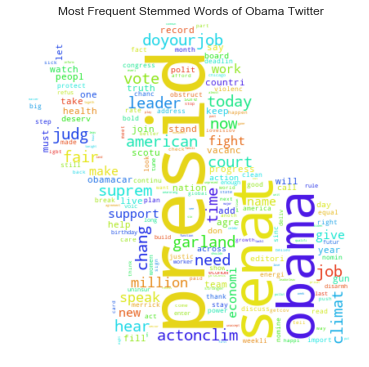

In [5]:
#word cloud image
                      
wordcloud = WordCloud(
    mask=imread('image/Obama.png'),
    background_color="white",)

wordcloud.generate(obama_twitter)

plt.figure()
plt.title("Most Frequent Stemmed Words of Obama Twitter")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("fig/word_clond_obama.png")
plt.show()


We can see that the most most frequent stemmed words of Obama's Twitter are *presid*, *senat* , *Obama*, *need*, *change*, *job*, *leader*, *American*. 

## Let's see the Most Frequent Stemmed Words of Trump's Twitter
We use the an Trump photo in `fig` folder to most the word cloud of the most frequent stemmed words of Trump's Twitter

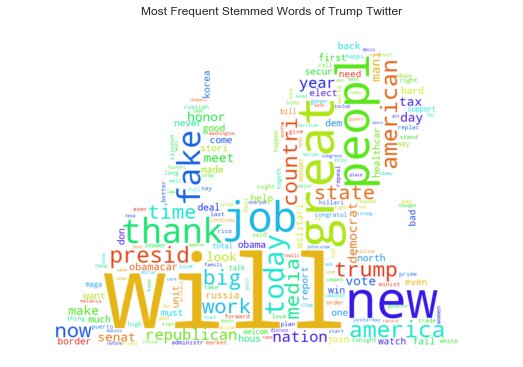

In [6]:
#word cloud image
                      
wordcloud = WordCloud(
    mask=imread('image/Trump.png'),
    background_color="white",)

wordcloud.generate(trump_twitter)

plt.figure()
plt.title("Most Frequent Stemmed Words of Trump Twitter")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("fig/word_clond_trump.png")
plt.show()


We can see that the most most frequent stemmed words of Trump's Twitter changed to  *will*, *new* , *great*, *thank*, *job*, *fake*, *presid*, *today*.

#### Compare the topic change by word cloud
It seems those words from Obama's tweets are related to people's need and jobs, Senate and himself. Those topic are more related to the community, e.g. *need*, *job*, *American*, *climat*.
The topic of Trump's twitter has changed to some invisible things, e.g. *will*, *great*, *thank*, *fake*. And its topic seems similar to his campaign slogan "Make America Great Again"

## Let's see the top 10 topics of Obama's Twitter
We will use the LDA to analyze the topic of the president's Obama last 10 Months and president's Trump first 10 twitter.LDA is  useful for finding reasonably accurate mixtures of topics within a given document set. We will use the pyLDAvis package to perform the 10 topics of Obama's Twitter. **Please be ready for the pop-up website.**

In [5]:
obama_list=[]
for i in flat_list_obama:
    obama_list.append(i)
warnings.filterwarnings('ignore')
dictionary_obama = corpora.Dictionary([obama_list])
corpus_obama = [dictionary_obama.doc2bow([text]) for text in flat_list_obama]
ldamodel_obama = models.ldamodel.LdaModel(corpus_obama, num_topics=10, id2word = dictionary_obama)
topic_obama_=[]
topic_obama=ldamodel_obama.print_topics(num_topics=10, num_words=12)
for i in range(len(topic_obama)):
    topic_obama[i]= re.sub(r'[^a-z\.]','', topic_obama[i][1]).replace('.',',')[1:]
topic_obama_pd = pd.DataFrame({'Top 10 Topic of Obama':topic_obama})
topic_obama_pd

,Top 10 Topic of Obama
0,"obama,fair,suprem,peopl,continu,enter,read,wan..."
1,"court,time,chang,live,economi,get,make,http,ke..."
2,"senat,hear,leader,watch,deadlin,chanc,will,mee..."
3,"judg,garland,give,climat,american,add,nation,o..."
4,"doyourjob,million,record,new,call,nomine,one,w..."
5,"support,need,chicago,take,day,america,voic,tea..."
6,"presid,now,name,speak,tune,vacanc,unit,board,e..."
7,",scotu,play,growth,believ,sector,qualifi,white..."
8,"actonclim,vote,job,merrick,deserv,say,see,heal..."
9,"today,fight,equal,agre,nomin,work,process,week..."


In [11]:
ldaobama =  pyLDAvis.gensim.prepare(ldamodel_obama, corpus_obama, dictionary_obama)
pyLDAvis.save_html(ldaobama, 'fig/ldaobama.html')

In [12]:
pyLDAvis.display(ldaobama)

##### The important word from the top 5 topics
- First topic are **fair, suprem, peopl, continu** 
- Second topic is **court, time, chang, live, economi** 
- Third topic is **senat, will, leader, think** 
- Forth topic is **judg, climat, american, obamacar** 
- Fifth topic is **doyourjob, new, women, gun** 

As we can see from the pyLDAvis visuliztion, most topic are related and a bit overlap. 

## Let's see the top 10 topics of Trump's Twitter

In [15]:
trump_list=[]
for i in flat_list_trump:
  trump_list.append(i)

In [16]:
warnings.filterwarnings('ignore')
dictionary_trump = corpora.Dictionary([trump_list])
corpus_trump = [dictionary_trump.doc2bow([text]) for text in flat_list_trump]
ldamodel_trump = models.ldamodel.LdaModel(corpus_trump, num_topics=10, id2word = dictionary_trump)
topic_trump_=[]
topic_trump=ldamodel_trump.print_topics(num_topics=10, num_words=12)
for i in range(len(topic_trump)):
  topic_trump[i]= re.sub(r'[^a-z\.]','', topic_trump[i][1]).replace('.',',')[1:]
topic_trump_pd = pd.DataFrame({'Top 10 Topic of trump':topic_trump})
topic_trump_pd


,Top 10 Topic of trump
0,"great,presid,can,border,long,call,prime,happen..."
1,",fake,bad,new,interview,tax,take,support,forwa..."
2,"countri,just,get,year,come,fail,enjoy,good,ord..."
3,"job,democrat,day,back,vote,hous,must,want,begi..."
4,"nation,work,tonight,unit,watch,don,wonder,neve..."
5,"thank,american,make,obama,honor,secur,obamacar..."
6,"big,meet,win,join,senat,allow,washington,toget..."
7,"will,now,russia,court,much,alway,see,statement..."
8,"peopl,today,america,trump,even,look,elect,cong..."
9,"news,media,state,time,mani,healthcar,republica..."


In [17]:
ldatrump =  pyLDAvis.gensim.prepare(ldamodel_trump, corpus_trump, dictionary_trump)
pyLDAvis.save_html(ldatrump, 'fig/ldatrump.html')

In [18]:
pyLDAvis.display(ldatrump)

##### The important word from the top 5 topics
- First topic are **great, border, presid, iran, terribl** 
- Second topic is **fake, new, interview, tax, administr,hard** 
- Third topic is **countri, just, come, made** 
- Forth topic is **job, democrat, vote, white** 
- Fifth topic is **work, execut, women, help** 

As we can see from the pyLDAvis visuliztion, some topic are related and a bit overlap. 

#### Compare the topic change by LDA
Most topics from Obama's tweets are related to social issue and the communtiy, e.g.  **peopl, fair, obamacar, economi, senat, climat, women, gun.**
I can guess from LDA analysis, his topics more about the economic, climate change, the women rights, obama care, gun control. Actually, he worked on this topic in his presidency.

Most topics from trump's tweets are related to national security, tax, media and his slogan "Make America Great Again" , e.g. **great, border, iran, fake, new, interview, tax**. I can guess from LDA analysis, his topics more about the his slogan "Make America Great Again", building wall along the Mexican border, blaming the media, Iran nuclear deal. Actually, he worked on this topic in his presidency. From the above result, we can say that the LDA perform well analyze the topic of twitter data.
 From the above result, we can say that the LDA perform well analyze the topic of twitter data.

In [23]:
topic_obama_pd.to_hdf('result/n3.h5','topicobama',table=True,mode='a')
topic_trump_pd.to_hdf('result/n3.h5','topictrump',table=True,mode='a')